# Imports

In [1]:
import torch
from datetime import datetime
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np

import sys
sys.path.append('../')
from src.utils.data_preprocessing import load_processed_data
from src.models.vgg16_1D import VGG16_1D
from src.utils.tensor_preprocessing import TensorPreprocessor
from src.utils.model_training import ModelTrainer
from src.utils.model_tresholds import ThresholdOptimizer
from src.utils.model_evaluation import ModelEvaluation

# Variables

In [19]:
SAMPLING_FREQUENCY = 100
TASK = "superdiagnostic"
CLASS_NAMES = ['MI', 'NORM', 'OTHER']

DATA_DIR = "../data/raw/ptb_xl_ecg/"
PREPROCESSED_DIR = f"../data/preprocessed/"
SCALER_DIR = f"../data/results/scaler/"

date_today = datetime.now().strftime("%Y_%m_%d")
MODEL_PATH = f"../src/models/trained/vgg16_1d_trained_{date_today}.pth"
HISTORY_PATH = f"../data/results/training_history/training_history_{date_today}.csv"
CHECKPOINT_PATH = f'../src/models/checkpoints/checkpoint_{date_today}.pth'

# Load Data

In [ ]:
X_train, y_train = load_processed_data(PREPROCESSED_DIR, "train", class_names=CLASS_NAMES)
X_val, y_val = load_processed_data(PREPROCESSED_DIR, "val", class_names=CLASS_NAMES)
X_test, y_test = load_processed_data(PREPROCESSED_DIR, "test", class_names=CLASS_NAMES)

In [7]:
splits = {'Train': y_train, 'Validation': y_val, 'Test': y_test}

for split_name, y_split in splits.items():
    y_arr = np.asarray(y_split)
    # Multi-Label: Summiere pro Klasse (Spalte)
    if y_arr.ndim == 2 and y_arr.shape[1] == len(CLASS_NAMES):
        counts = y_arr.sum(axis=0)
    else:
        counts = np.bincount(y_arr, minlength=len(CLASS_NAMES))
    perc = counts / counts.sum() * 100
    print(f"{split_name}:")
    for name, c, p in zip(CLASS_NAMES, counts, perc):
        print(f"  {name}: {int(c)} ({p:.2f}%)")
    print(f"  TOTAL: {int(counts.sum())} (100.00%)\n")

Train:
  MI: 4379 (25.63%)
  NORM: 7595 (44.46%)
  OTHER: 5110 (29.91%)
  TOTAL: 17084 (100.00%)

Validation:
  MI: 540 (25.16%)
  NORM: 955 (44.50%)
  OTHER: 651 (30.34%)
  TOTAL: 2146 (100.00%)

Test:
  MI: 550 (25.49%)
  NORM: 963 (44.62%)
  OTHER: 645 (29.89%)
  TOTAL: 2158 (100.00%)



# Load Model and Optimizer

In [8]:
model = VGG16_1D(in_channels=12, num_classes=len(CLASS_NAMES), input_length=1000)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Load Tensors

In [9]:
tp = TensorPreprocessor()

In [10]:
# Trainingsdaten (und Labels) in TensorDataset umwandeln, inkl. Permute falls nötig
train_dataset = tp.to_dataset(X_train, y_train.astype(np.float32), expected_channels=12, expected_length=1000)
val_dataset = tp.to_dataset(X_val, y_val.astype(np.float32), expected_channels=12, expected_length=1000)
test_dataset = tp.to_dataset(X_test, y_test.astype(np.float32), expected_channels=12, expected_length=1000)

[Auto-Fix] Initiale Prüfung:
--- Tensor Shape Check ---
X_tensor: shape=(17084, 1000, 12), dtype=torch.float32
y_tensor: shape=(17084, 3), dtype=torch.int64
Warnung: Channels (X_tensor.shape[1]=1000) stimmt nicht mit expected_channels=12 überein!
Warnung: Length (X_tensor.shape[2]=12) stimmt nicht mit expected_length=1000 überein!
--------------------------
[Auto-Fix] Versuche Shape automatisch zu korrigieren...
Shape-Fix: Permutiere von (Batch, Length, Channels) zu (Batch, Channels, Length)
--- Tensor Shape Check ---
X_tensor: shape=(17084, 12, 1000), dtype=torch.float32
y_tensor: shape=(17084, 3), dtype=torch.int64
Alles korrekt: Tensor-Formate stimmen überein.
--------------------------
[Auto-Fix] Initiale Prüfung:
--- Tensor Shape Check ---
X_tensor: shape=(2146, 1000, 12), dtype=torch.float32
y_tensor: shape=(2146, 3), dtype=torch.int64
Warnung: Channels (X_tensor.shape[1]=1000) stimmt nicht mit expected_channels=12 überein!
Warnung: Length (X_tensor.shape[2]=12) stimmt nicht mit 

In [11]:
train_dataset.tensors = (train_dataset.tensors[0], train_dataset.tensors[1].float())
val_dataset.tensors = (val_dataset.tensors[0], val_dataset.tensors[1].float())
test_dataset.tensors = (test_dataset.tensors[0], test_dataset.tensors[1].float())

In [12]:
# DataLoader erzeugen
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model Training

## Training from scratch

In [13]:
# y_train enthält alle Trainingslabels als Multi-Hot (Multi-Label)
if isinstance(y_train, np.ndarray) and y_train.ndim == 2:
    class_counts = y_train.sum(axis=0)
else:
    class_counts = np.bincount(y_train)

In [14]:
class_weights = 1.0 / class_counts   # Inverse Häufigkeit
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normierung
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Initialize the loss function, used for
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

In [ ]:
# Initialize the ModelTrainer, for managing the training process
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, criterion, CHECKPOINT_PATH)

In [17]:
# Start training the model mit Evaluation nach jeder Epoche (Multi-Label)
thresholds = [0.3, 0.7, 0.3]  # MI, NORM, OTHER
epochs = 10
trainer.train(num_epochs=epochs, eval_fn=ModelEvaluation.compute_metrics, threshold=thresholds)

Epoch 1/10 - Train Loss: 0.4347 - Val Loss: 0.4034
Metrics (Training): {'accuracy': 0.47488878482790914, 'f1_weighted': 0.6460455378624363, 'precision_weighted': 0.6779351745648392, 'recall_weighted': 0.6723249824397096, 'f1_per_class': [0.607601909658465, 0.6931233933161953, 0.6090178149140785], 'precision_per_class': [0.5080608014739751, 0.8889346795796415, 0.5098996832101372], 'recall_per_class': [0.7556519753368349, 0.5680052666227782, 0.7559686888454011]}
Metrics (Validation): {'accuracy': 0.4874184529356943, 'f1_weighted': 0.672083880589856, 'precision_weighted': 0.6880777891342834, 'recall_weighted': 0.7273998136067101, 'f1_per_class': [0.5914994096812278, 0.7298636926889716, 0.6541666666666667], 'precision_per_class': [0.4341421143847487, 0.8937784522003035, 0.596958174904943], 'recall_per_class': [0.9277777777777778, 0.6167539267015707, 0.7235023041474654]}


Epoch 2/10 - Train Loss: 0.3505 - Val Loss: 0.3987
Metrics (Training): {'accuracy': 0.6244439241395457, 'f1_weighted': 0.7343013544207048, 'precision_weighted': 0.7407926702724441, 'recall_weighted': 0.7612971201123858, 'f1_per_class': [0.7074936411661124, 0.7774346614446035, 0.6931650549090314], 'precision_per_class': [0.618860174567859, 0.9083069341781063, 0.5963056965595037], 'recall_per_class': [0.8257593057775748, 0.6795260039499671, 0.8275929549902152]}
Metrics (Validation): {'accuracy': 0.6272134203168686, 'f1_weighted': 0.7208739832545812, 'precision_weighted': 0.7550699983125361, 'recall_weighted': 0.7250698974836906, 'f1_per_class': [0.6909469302809573, 0.7758215962441315, 0.6650915534554046], 'precision_per_class': [0.7885985748218527, 0.8825100133511349, 0.5403071017274472], 'recall_per_class': [0.6148148148148148, 0.6921465968586388, 0.8648233486943164]}


Epoch 3/10 - Train Loss: 0.3236 - Val Loss: 0.3630
Metrics (Training): {'accuracy': 0.6605595879185202, 'f1_weighted': 0.7552207358407962, 'precision_weighted': 0.7611456571069963, 'recall_weighted': 0.7809646452821354, 'f1_per_class': [0.7276462531794169, 0.7960699017475437, 0.7181364392678868], 'precision_per_class': [0.6364881054252952, 0.9248867201115372, 0.624602026049204], 'recall_per_class': [0.8492806576844029, 0.6987491770901909, 0.8446183953033268]}
Metrics (Validation): {'accuracy': 0.657502329916123, 'f1_weighted': 0.7503679110529445, 'precision_weighted': 0.7508390378432592, 'recall_weighted': 0.7749301025163094, 'f1_per_class': [0.7219047619047619, 0.8144796380090498, 0.6799276672694394], 'precision_per_class': [0.7431372549019608, 0.8856088560885609, 0.5595238095238095], 'recall_per_class': [0.7018518518518518, 0.7539267015706806, 0.8663594470046083]}


Epoch 4/10 - Train Loss: 0.3020 - Val Loss: 0.3789
Metrics (Training): {'accuracy': 0.6866658862093187, 'f1_weighted': 0.770996497774667, 'precision_weighted': 0.7769128868334174, 'recall_weighted': 0.7932568485132288, 'f1_per_class': [0.7524850894632207, 0.8070096942580164, 0.7333333333333333], 'precision_per_class': [0.6662559408554832, 0.930524505588994, 0.6434268833087149], 'recall_per_class': [0.8643525919159626, 0.712442396313364, 0.8524461839530333]}
Metrics (Validation): {'accuracy': 0.6770736253494875, 'f1_weighted': 0.7562678870803637, 'precision_weighted': 0.7402521277359282, 'recall_weighted': 0.7898415657036346, 'f1_per_class': [0.7125119388729704, 0.8364813815434431, 0.674892041949414], 'precision_per_class': [0.7357001972386588, 0.8630289532293987, 0.5639175257731959], 'recall_per_class': [0.6907407407407408, 0.8115183246073299, 0.8402457757296466]}


Epoch 5/10 - Train Loss: 0.2861 - Val Loss: 0.3819
Metrics (Training): {'accuracy': 0.7018848044954343, 'f1_weighted': 0.7831989649372315, 'precision_weighted': 0.7866376321795315, 'recall_weighted': 0.8053149145399204, 'f1_per_class': [0.766055969398027, 0.8171931641636457, 0.7473639814424293], 'precision_per_class': [0.684968496849685, 0.9326241134751773, 0.6567828020756116], 'recall_per_class': [0.8689198447134049, 0.727188940092166, 0.8669275929549902]}
Metrics (Validation): {'accuracy': 0.6663560111835974, 'f1_weighted': 0.7652847592291955, 'precision_weighted': 0.7350450892604604, 'recall_weighted': 0.8028890959925443, 'f1_per_class': [0.7291666666666666, 0.8438642297650131, 0.679970436067997], 'precision_per_class': [0.6426553672316384, 0.8416666666666667, 0.6552706552706553], 'recall_per_class': [0.8425925925925926, 0.8460732984293193, 0.706605222734255]}


Epoch 6/10 - Train Loss: 0.2733 - Val Loss: 0.4075
Metrics (Training): {'accuracy': 0.7131819246078202, 'f1_weighted': 0.7917328183674354, 'precision_weighted': 0.792897009493914, 'recall_weighted': 0.8142706626082885, 'f1_per_class': [0.771448593452798, 0.8296840558412931, 0.752708351104666], 'precision_per_class': [0.6868092691622103, 0.9386533665835411, 0.6671707243308634], 'recall_per_class': [0.8798812514272665, 0.7433838051349572, 0.8634050880626223]}
Metrics (Validation): {'accuracy': 0.6840633737185461, 'f1_weighted': 0.7541613131386646, 'precision_weighted': 0.749214644797409, 'recall_weighted': 0.7777260018639329, 'f1_per_class': [0.698477157360406, 0.8404710920770878, 0.6737367436057392], 'precision_per_class': [0.7730337078651686, 0.859802847754655, 0.5672268907563025], 'recall_per_class': [0.6370370370370371, 0.8219895287958116, 0.8294930875576036]}


Epoch 7/10 - Train Loss: 0.2562 - Val Loss: 0.3605
Metrics (Training): {'accuracy': 0.7399321002107235, 'f1_weighted': 0.807931306052933, 'precision_weighted': 0.8085115905190742, 'recall_weighted': 0.8278506204635917, 'f1_per_class': [0.7876767676767676, 0.8410301305902094, 0.776093546990039], 'precision_per_class': [0.7062126426372034, 0.9430628272251309, 0.6961926961926962], 'recall_per_class': [0.8903859328613839, 0.7589203423304806, 0.8767123287671232]}
Metrics (Validation): {'accuracy': 0.6724137931034483, 'f1_weighted': 0.7388297597105736, 'precision_weighted': 0.7612350014428719, 'recall_weighted': 0.7530288909599254, 'f1_per_class': [0.7328833172613307, 0.7817319098457889, 0.6808259587020649], 'precision_per_class': [0.7645875251509054, 0.9015047879616963, 0.5526819923371648], 'recall_per_class': [0.7037037037037037, 0.6900523560209424, 0.8863287250384024]}


Epoch 8/10 - Train Loss: 0.2413 - Val Loss: 0.3433
Metrics (Training): {'accuracy': 0.7564973074221494, 'f1_weighted': 0.822129836186867, 'precision_weighted': 0.8185183528173029, 'recall_weighted': 0.8437719503629126, 'f1_per_class': [0.804810926511059, 0.8584824004616273, 0.7829403606102635], 'precision_per_class': [0.7268041237113402, 0.9492742064125059, 0.702769996887644], 'recall_per_class': [0.9015757022151176, 0.7835418038183015, 0.8837573385518591]}
Metrics (Validation): {'accuracy': 0.6607642124883504, 'f1_weighted': 0.7418028618958584, 'precision_weighted': 0.747032379655124, 'recall_weighted': 0.7684063373718546, 'f1_per_class': [0.7226107226107226, 0.7804295942720764, 0.701058201058201], 'precision_per_class': [0.6224899598393574, 0.9070735090152566, 0.6155632984901278], 'recall_per_class': [0.8611111111111112, 0.6848167539267016, 0.8141321044546851]}


Epoch 9/10 - Train Loss: 0.2258 - Val Loss: 0.3649
Metrics (Training): {'accuracy': 0.7670920159213299, 'f1_weighted': 0.8303523143552191, 'precision_weighted': 0.8253194892447877, 'recall_weighted': 0.8532545071411848, 'f1_per_class': [0.8089567430025445, 0.867544427656666, 0.7934084995663486], 'precision_per_class': [0.7297098788101358, 0.9563769035532995, 0.7124610591900311], 'recall_per_class': [0.9075131308517926, 0.7938117182356814, 0.8951076320939335]}
Metrics (Validation): {'accuracy': 0.6887232059645852, 'f1_weighted': 0.7577551750429229, 'precision_weighted': 0.7400667529890567, 'recall_weighted': 0.7865796831314072, 'f1_per_class': [0.7271241830065359, 0.8198347107438017, 0.6920943134535368], 'precision_per_class': [0.6505847953216374, 0.8651162790697674, 0.6308470290771175], 'recall_per_class': [0.8240740740740741, 0.7790575916230367, 0.7665130568356375]}


Epoch 10/10 - Train Loss: 0.2089 - Val Loss: 0.4542
Metrics (Training): {'accuracy': 0.790915476469211, 'f1_weighted': 0.8463105579897249, 'precision_weighted': 0.8416346512653204, 'recall_weighted': 0.8648442987590729, 'f1_per_class': [0.8279492207658169, 0.8807012542759407, 0.8109303148213654], 'precision_per_class': [0.7553672316384181, 0.9599192170265651, 0.7397547595998709], 'recall_per_class': [0.9159625485270609, 0.8135615536537195, 0.8972602739726028]}
Metrics (Validation): {'accuracy': 0.7003727865796832, 'f1_weighted': 0.7582921963981174, 'precision_weighted': 0.740057610826574, 'recall_weighted': 0.7847157502329916, 'f1_per_class': [0.7342465753424657, 0.8252947481243301, 0.6799468791500664], 'precision_per_class': [0.7243243243243244, 0.845225027442371, 0.5988304093567252], 'recall_per_class': [0.7444444444444445, 0.806282722513089, 0.7864823348694316]}


In [ ]:
# Saving
trainer.save_model(MODEL_PATH)
trainer.save_training_history(HISTORY_PATH)
# Checkpoint is saved automatically at the end of training

## Training from Checkpoint

In [ ]:
# Modell Optimierer müssen bereits neu initialisiert sein
# model = VGG16_1D(in_channels=12, num_classes=len(CLASS_NAMES), input_length=1000)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# trainer = ModelTrainer(model, train_loader, val_loader, optimizer, criterion)
# checkpoint_path = 'checkpoint.pth'
# thresholds = [0.3, 0.7, 0.3]  # MI, NORM, OTHER

In [ ]:
# Lade letzten Checkpoint
# load_checkpoint-Methode gibt die Epochennummer zurück, um das Training fortzusetzen
start_epoch = trainer.load_checkpoint(CHECKPOINT_PATH)

# Training fortsetzen
epochs_to_continue = 20
trainer.train(num_epochs=epochs_to_continue, eval_fn=ModelEvaluation.compute_metrics, threshold=thresholds, start_epoch=start_epoch)

In [ ]:
# Saving
trainer.save_model(MODEL_PATH)
trainer.save_training_history(HISTORY_PATH)
# Checkpoint is saved automatically at the end of training

## Load trained Model

In [35]:
# load existing model

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
trainer = ModelTrainer(model, None, None, optimizer, criterion)

# 2. Modell und Historie über die Instanz laden
trainer.load_model(MODEL_PATH)
trainer.load_training_history(HISTORY_PATH)

Fehler: Spalte 'val_accuracy' in der CSV-Datei fehlt. Überprüfen Sie das Dateiformat.


c:\Users\AliceKitchkin\Repos\ECG_xAI\notebooks\..\src\utils\model_training.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  path: Path to save the model


## Thresholds

In [38]:
# Nach dem Modelltraining: Validierungslauf
y_true_val, y_probs_val = trainer.inferencing(val_loader)

In [39]:
# CLASS_NAMES = ['MI', 'NORM', 'OTHER']
metrics_config = {0: 'recall_weighted', 1: 'precision_weighted', 2: 'recall_weighted'}
threshold_optimizer = ThresholdOptimizer(metrics_config, beta=1.5)

In [40]:
optimal_thresholds = threshold_optimizer.optimize(y_true_val, y_probs_val)
print(f"Finale optimierte Schwellenwerte: {optimal_thresholds}")

Optimizing Thresholds: 100%|██████████| 3/3 [00:00<00:00, 97.43it/s]

Optimaler Schwellenwert für Label 0 (recall_weighted): 0.15 mit Score 0.4899
Optimaler Schwellenwert für Label 1 (precision_weighted): 0.65 mit Score 0.6152
Optimaler Schwellenwert für Label 2 (recall_weighted): 0.15 mit Score 0.4596
Finale optimierte Schwellenwerte: {0: 0.15000000000000002, 1: 0.6500000000000001, 2: 0.15000000000000002}


# Evaluation on Validation Data

In [41]:
y_pred_val = (y_probs_val >= list(optimal_thresholds.values())).astype(int)

In [42]:
# Metriken berechnen und ausgeben
val_metrics = ModelEvaluation.compute_metrics(y_true_val, y_pred_val)
ModelEvaluation.print_metrics(val_metrics, class_names=CLASS_NAMES)


--- Evaluation Metrics ---
accuracy: 0.6249
f1_weighted: 0.7577
precision_weighted: 0.7049
recall_weighted: 0.8364
f1_per_class:
  MI: 0.7227
  NORM: 0.8357
  OTHER: 0.6723
precision_per_class:
  MI: 0.6458
  NORM: 0.8433
  OTHER: 0.5511
recall_per_class:
  MI: 0.8204
  NORM: 0.8283
  OTHER: 0.8618


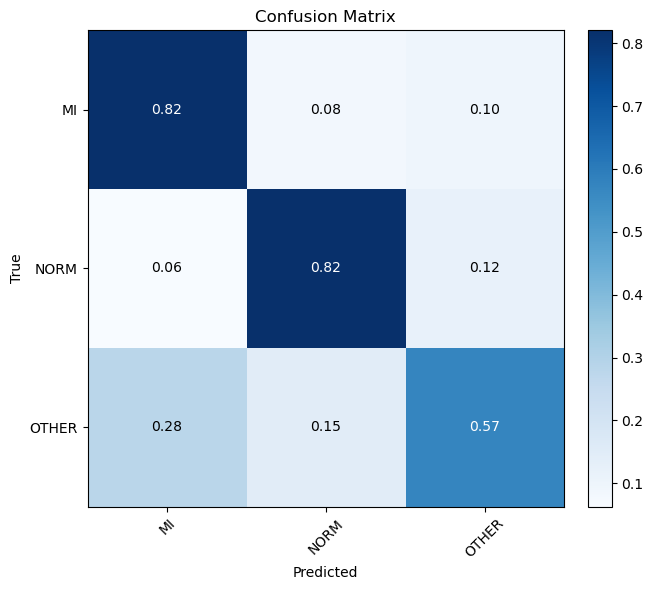

In [43]:
ModelEvaluation.plot_confusion_matrix(y_true_val, y_pred_val, class_names=CLASS_NAMES, normalize=True)

In [44]:
# Loss-Kurven plotten (hierfür werden die in der Trainer-Klasse gespeicherten Verluste benötigt)
# Trainer.train_losses, Trainer.val_losses, Trainer.train_losses_per_class, Trainer.val_losses_per_class
# Annahme: Sie haben diese Werte vom Trainer-Objekt gespeichert oder als Attribut zugänglich gemacht.
# Beispiel:
# trainer = ModelTrainer(...)
# trainer.train(...)
# ModelEvaluation.plot_loss_curves(
#     train_losses=trainer.train_losses, 
#     val_losses=trainer.val_losses,
#     train_losses_per_class=trainer.train_losses_per_class,
#     val_losses_per_class=trainer.val_losses_per_class,
#     class_names=CLASS_NAMES
# )

# Evaluation on Test Data

In [45]:
y_true_test, y_probs_test = trainer.inferencing(test_loader)

In [46]:
y_pred_test = (y_probs_test >= list(optimal_thresholds.values())).astype(int)

In [47]:
test_metrics = ModelEvaluation.compute_metrics(y_true_test, y_pred_test)
ModelEvaluation.print_metrics(test_metrics, class_names=CLASS_NAMES)


--- Evaluation Metrics ---
accuracy: 0.6131
f1_weighted: 0.7501
precision_weighted: 0.6948
recall_weighted: 0.8304
f1_per_class:
  MI: 0.7176
  NORM: 0.8280
  OTHER: 0.6614
precision_per_class:
  MI: 0.6436
  NORM: 0.8263
  OTHER: 0.5421
recall_per_class:
  MI: 0.8109
  NORM: 0.8297
  OTHER: 0.8481


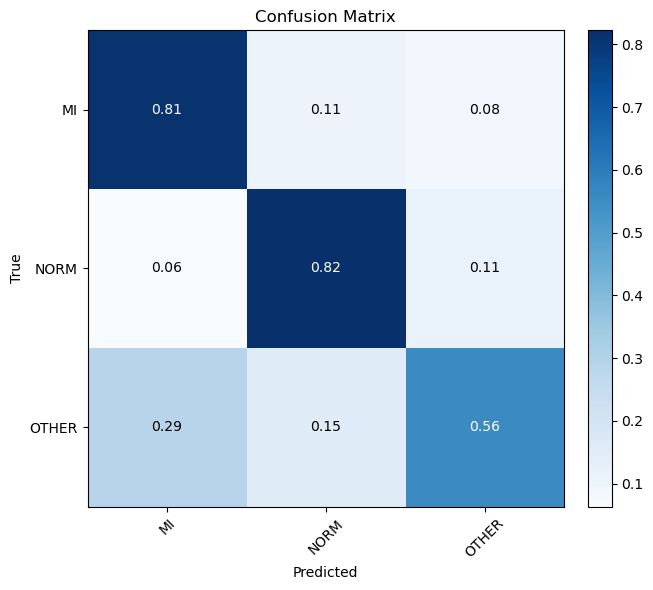

In [48]:
ModelEvaluation.plot_confusion_matrix(y_true_test, y_pred_test, class_names=CLASS_NAMES, normalize=True)